# Intermediate Machine Learning: Assignment 3

**Deadline**

Assignment 3 is due Wednesday, October 30 by 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a pdf file on Gradescope, and as a notebook (.ipynb) on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:

Go to "File" at the top-left of your Jupyter Notebook
Under "Download as", select "HTML (.html)"
After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
From the print window, select the option to save as a .pdf

**Topics**

 * Variational autoencoders
 * Undirected graphs
 * The graphical lasso

This assignment will also help to solidify your Python and Jupyter notebook skills.


## Problem 1: Face time (35 points)

In this problem, we will implement a "shoestring" version of [this amazing fake face generator](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html), using a variational autoencoder (VAE). Building a generator like the one featured in the article can take a tremendous amount of computational resources, time, and parameter tuning. In this problem we will build a basic version to illustrate the main concepts, and help you to become more famililar with VAEs.  Here is an outline of the process that we'll step you through:

### Problem outline:

* Load data
* Create face groups based on attributes
* Construct the VAE
* Define the loss function and train the VAE (Problem 1.1)
* Encode and reconstruct faces (Problem 1.2)
* Visualize the latent space (Problem 1.3)
* Morph between faces (Problem 1.4)
* Shift attributes of faces (Problem 1.5)
* Generate new faces (Problem 1.6)
* Analyze the effect of the scaling factor in the loss function (Problem 1.7, optional)

In the next cell we load the packages that we'll need. If you don't have one or more of these, you can install them with `!pip install <package_name>` in the cell, or outside the notebook
with `conda install -c conda-forge <package_name>`

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

### Loading the data

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) is a database of face photographs. The images are placed in the folder lfw-deepfunneled. lfw_attributes.txt is a document including a set of attributes associated for each image, such as 'Male', 'Smile', 'Bold', etc. All the features are numerical and large positive values indicate that the keywords well describe the photo; large negative values indicate that the keywords don't fit the photo.

For this problem, we will keep only the middle parts of the photos to avoid complex backgrounds.

Download the data from the cloud at these URLs:

https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
<br>
https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

Once you have the data, unzip it, and place it in a directory that we will call "YOUR_PATH" below.
  
Run all the cells in this section to load the data.

Note: Please write down the entire path instead of using something like '~/Desktop/datasets/' to avoid unnecessary compiling errors. Also, if you choose to use Colab to do your homework. We need to download the data into the same directory as your code. You may also need

"from google.colab import drive"

"drive.mount('/content/drive')"

to enable using paths in Google Drive before starting your code below. But personally, I would suggest using jupyter notebook to run the code locally instead of using Google Colab since the latter may take longer time.

In [ ]:
# Change these path names to correspond with your directory
DATASET_PATH ="/YOUR_PATH/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/YOUR_PATH/lfw_attributes.txt"

In [ ]:
# Make sure the above path is correct before running this cell
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})

dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 100 )
dataset.head(10)

The following cell will display some sample images

In [ ]:
sampled_id = []

plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
    sampled_id.append(idx)
plt.tight_layout()
plt.show()

The following cell shows the images with some of the background removed.

In [ ]:
dx=70
dy=70

plt.figure(figsize=(20,10))
for i in range(20):
    idx = sampled_id[i]
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img[dy:-dy,dx:-dx])
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

The following function crops the images to 45x45 pixels, which is what we will use in this problem.

In [ ]:
def fetch_dataset(dx=70, dy=70, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [ ]:
data, attrs = fetch_dataset()
data = np.array(data / 255, dtype='float32')

### Create Face Groups

We can now create groups of faces, by selecting the faces having the highest or lowest scores for each of the attributes. Run all the cells in this section to create and plot some face groups.

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.75 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

In [ ]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).head(36).index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(36).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(36).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(36).index.values
sunglasses_data = data[sunglasses_ids]

mustache_ids = attrs['Mustache'].sort_values(ascending=False).head(36).index.values
mustache_data = data[mustache_ids]

male_ids = attrs['Male'].sort_values(ascending=False).head(36).index.values
male_data = data[male_ids]

female_ids = attrs['Male'].sort_values(ascending=True).head(36).index.values
female_data = data[female_ids]

eyeclosed_ids = attrs['Eyes Open'].sort_values(ascending=True).head(36).index.values
eyeclosed_data = data[eyeclosed_ids]

mouthopen_ids = attrs['Mouth Wide Open'].sort_values(ascending=False).head(36).index.values
mouthopen_data = data[mouthopen_ids]

makeup_ids = attrs['Heavy Makeup'].sort_values(ascending=False).head(36).index.values
makeup_data = data[makeup_ids]

In [ ]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=smile_ids)

In [ ]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=no_smile_ids)

In [ ]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeglasses_ids)

In [ ]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=sunglasses_ids)

In [ ]:
plot_gallery(mustache_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mustache_ids)

In [ ]:
plot_gallery(male_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=male_ids)

In [ ]:
plot_gallery(female_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=female_ids)

In [ ]:
plot_gallery(eyeclosed_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=eyeclosed_ids)

In [ ]:
plot_gallery(mouthopen_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=mouthopen_ids)

In [ ]:
plot_gallery(makeup_data, IMAGE_H, IMAGE_W, n_row=6, n_col=6, with_title=True, titles=makeup_ids)

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [ ]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
input_data = tensorflow.keras.layers.Input(shape=(45, 45, 3))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)

distribution_mean = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=LATENT_SPACE_SIZE)
decoder = tensorflow.keras.layers.Reshape((1, 1, 100))(decoder_input)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(16, (5,5), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(3, (6,6), activation='relu')(decoder)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = tensorflow.math.squared_difference(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_sum(reconstruction_loss)/batch_size
        return 0.5*reconstruction_loss_batch*factor

    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = LATENT_SPACE_SIZE + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_sum(kl_loss)/batch_size
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

### 1.1 Deriving the loss function (5 points)

Derive the loss function defined in the cell above from the probability model perspective. You can ignore the scalar `factor` in your derivation. Show your work using either LaTeX or a picture of your written solution.

Hint: Think about how how the total loss is related to the ELBO.

[Your derivation here]

The following three cells train the model. You can just run them. It may take a while to run on your laptop.

In [ ]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=365)

In [ ]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val))

In [ ]:
# Save your trained model (for later use)

# autoencoder.save("My_Trained_VAE")
# encoder_model.save("My_Trained_encoder")
# decoder_model.save("My_Trained_decoder")

If you experience issues while training the models above or if the process is taking too long, you may also use our pre-trained versions of the VAE, encoder, and decoder, which are available on Canvas.

No points will be taken off if you decide to use the pre-trained models, but we do recommend trying out the training process above. In case you encounter any issues when loading in the models, please post your questions on Ed discussion.

In [ ]:
# Load Pre-trained Model

# batch_size = 64
# autoencoder = tensorflow.keras.models.load_model("Trained_VAE",compile=False)
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

# encoder_model = tensorflow.keras.models.load_model("Trained_encoder",compile=False)
# encoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

# decoder_model = tensorflow.keras.models.load_model("Trained_decoder",compile=False)
# decoder_model.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100, batch_size = batch_size), optimizer='Adam')

### 1.2 Reconstructing faces (3 points)

The following cell encodes and reconstructs 16 random faces from the validation set with the trained VAE. Run the cell and comment on the reconstructed faces. (3 points)
* Do the reconstructed faces resemble the original images? How are they similar/different?
* Are there any faces that are reconstructed better or worse than the others? Can you think of why?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
sample_index = random.sample(range(1, len(X_val)), 16)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(X_val[sample_index[4*i+j], :, :, :])
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(np.clip(autoencoder.predict(np.array([X_val[sample_index[4*i+j], :, :, :]]))[0],0,1))
        axs[i, 2*j+1].axis('off')

[Your markdown here]

### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [ ]:
def LatentSpace_2D(encoder_model, data1, label1, data2, label2):
    # Your code here

In [ ]:
LatentSpace_2D(encoder_model, smile_data, 'Smile', no_smile_data, 'No smile')

In [ ]:
LatentSpace_2D(encoder_model,smile_data,'No sunglasses',sunglasses_data,'Sunglasses')

In [ ]:
LatentSpace_2D(encoder_model,male_data,'Male',female_data,'Female')

[Your markdown here]

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

In [ ]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

In [ ]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)

### 1.5 Attribute shift (10 points)

In 1.3, we've seen that faces with the same attributes form clusters in the latent space. In this problem, you will implement a function `AttributeShift` to change one attribute of the faces.

First implement the function `AttributeShift`. (5 points)
1. Calculate the latent space codes for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Calculate the mean latent space code for each group.
3. Get the attribute shifting vector by taking the difference between the two codes.
4. Perform attribute shift by adding the attribute shifting vector to the latent space code of the faces you want to modify.
5. Generate the image using the new latent space codes.

Here is a diagram demonstrating the shift in the latent space. Please note that the two-dimensional latent space is just for demonstration purpose. You should *not* use PCA in this problem. Instead, use the original latent space.
![Diagram_1_5](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Diagram_1_5.png)

Perform attribute shift on at three attributes including smile. Comment on the faces with shifted attributes. (5 points)
* Do the generated faces look like what you expected? If not, can you think of some possible reasons?
* Do the faces with new attributes resemble the original faces? If not, can you think of some possible reasons?
* Which of the attribute shift is more successful? What are some possible reasons?
* Comment on any other aspects of your findings that are interesting to you.

In [ ]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [ ]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    # Your code here
    return pic_output

In [ ]:
pic_output = AttributeShift(encoder_model,decoder_model,smile_data,no_smile_data)
PlotAttributeShift(no_smile_data,pic_output)

[Your markdown here]

### 1.6 Generating new faces (3 points)

Variational autoencoders can be used to generate new data; this is why they are generative models. We can sample new data points from the distribution in latent space and reconstruct new, fake faces based on them.

To draw a sample close to an existing sample in the latent space, we can add a scaled random sample from the normal distribution to the latent space code of an existing sample. The scalar, which we call the `noise_level` is a parameter that we can tune.

Run `GenerateFaces` with three different values of `noise_level` and comment on the generated faces. (3 points)
* Do the generated images look like faces?
* What happens when the new samples diverge more from the existing samples? What is a possible reason?

In [ ]:
def GenerateFaces(data, LATENT_SPACE_SIZE, noise_level):
    sample_index = random.sample(range(1, len(data)), 15)
    latent_space = noise_level*np.random.normal(size=(15,LATENT_SPACE_SIZE))+encoder_model.predict(data[sample_index])
    generated_image = decoder_model.predict(latent_space)
    fig = plt.figure(figsize=(15,10))
    for i in range(number_of_images):
        ax = fig.add_subplot(3, 5, i+1)
        ax.imshow(np.clip(generated_image[i, :,:,:],0,1))
        ax.axis('off')

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.1)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,0.5)

In [ ]:
GenerateFaces(data,LATENT_SPACE_SIZE,1)

In [ ]:
# Your markdown here

### Optional: Changing the loss function (2 points extra credit)

The variable `factor` is a parameter of the loss function. In this optional problem, you will play with it and think about its effect on the performance of VAE.

Retrain the model with a smaller factor. Repeat 1.2, 1.6 (using `noise_level` = 1) and latent space visualization. Comment on how the reconstruction results, generated new faces and latent space distributions change. (2 points)
* Which model reconstructs the faces better?
* Do the generated faces look different?
* How do the latent variable distributions differ?
* Do the differences make sense? Can you explain what you observed?

In [ ]:
# Your code here

[Your markdown here]

$\newcommand{\reals}{{\mathbb R}}
\newcommand{\indp}{\perp\kern-4pt\perp}
\newcommand{\given}{\,|\,}
$

## Problem 2: Are you Schur? (10 points)

The graphical lasso is based on conditional independence properties
of Gaussian distributions. This problem asks you to reason about the graphs
underlying a multivariate Gaussian.

Let $X = (Y,Z) \in \reals^6 \sim N(0, \Sigma)$ be a random
Gaussian vector where $Y = (Y_1,Y_2) \in\reals^2$ and
$Z = (Z_1,Z_2,Z_3,Z_4) \in\reals^4$, with
$\Sigma^{-1} = \Omega =  \begin{pmatrix}
A & B \\
B^T & C
\end{pmatrix}
$
where
$$
A = \begin{pmatrix} 2 & 0 \\ 0 & 2\end{pmatrix} \qquad
B = \begin{pmatrix} 1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} \\[1pt]
                     -1 & \frac{1}{2} & -\frac{1}{3} & \frac{1}{4}
\end{pmatrix} \qquad
C = \begin{pmatrix}
2 & \frac{1}{2} & 0 & 0 \\
\frac{1}{2} & 2 & 0 & 0 \\
0 & 0 & 2 & \frac{1}{2} \\
0 & 0 & \frac{1}{2} & 2
\end{pmatrix}.
$$

### Problem 2.1

Draw the undirected graph of $X$, arranging the vertices in a hexagon. Explain your answer.

$$
A = \begin{pmatrix} 2 & 0 \\ 0 & 2\end{pmatrix} \qquad
B = \begin{pmatrix} 1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} \\[1pt]
                     -1 & \frac{1}{2} & -\frac{1}{3} & \frac{1}{4}
\end{pmatrix} \qquad
C = \begin{pmatrix}
2 & \frac{1}{2} & 0 & 0 \\
\frac{1}{2} & 2 & 0 & 0 \\
0 & 0 & 2 & \frac{1}{2} \\
0 & 0 & \frac{1}{2} & 2
\end{pmatrix}.
$$

<br>

### Answer 2.1

Combining A, B, C, we can construct: $$
\Omega = \begin{pmatrix} 
    2 & 0 & 1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} \\ 
    0 & 2 & -1 & \frac{1}{2} & -\frac{1}{3} & \frac{1}{4} \\
    1 & -1 & 2 & \frac{1}{2} & 0 & 0 \\
    \frac{1}{2} & \frac{1}{2} & \frac{1}{2} & 2 & 0 & 0 \\
    \frac{1}{3} & -\frac{1}{3} & 0 & 0 & 2 & \frac{1}{2} \\
    \frac{1}{4} & \frac{1}{4} & 0 & 0 & \frac{1}{2} & 2
    \end{pmatrix} \qquad
$$

There are 6 diagnoal elements. Let $v_i \in V=\{i \, | \, \Omega_{ii} \, \text{exists}\}$ denote each vertex in the hexagon graph. 

We draw an edge connecting vertex $v_i \in V$ and $v_j \in V$ if $\Omega_{ij} = \Omega_{ji} \neq 0$ by proposition introduced in class. Thus, we have:


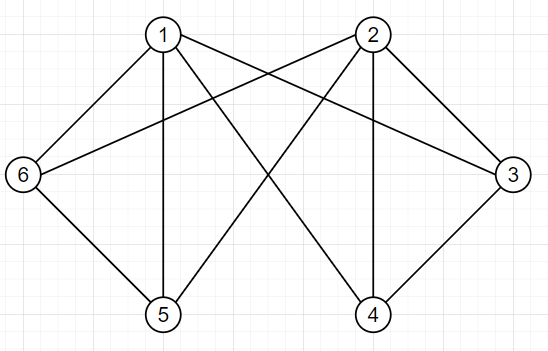

### Problem 2.2

Draw the undirected graph of $Z$, arranging the vertices in a square.  Explain your answer.
Hint:  The
[Schur complement](https://en.wikipedia.org/wiki/Schur_complement)
$ S= C  - B^T A^{-1} B$ has the property that

\begin{equation*}
\begin{pmatrix}
A & B \\
B^T & C
\end{pmatrix}^{-1}
\;=\;
\begin{pmatrix}
A^{-1} + A^{-1} B S^{-1} B ^T A^{-1} & - A^{-1} B S^{-1}  \\
- S^{-1} B^T A^{-1} & S^{-1}
\end{pmatrix}
\end{equation*}


<br>

### Answer 2.2

**_Lemma 1_**: $Z \in \reals^4 \sim N(0, \, S^{-1})$, where $S = C - B^TA^{-1}B$ and $\Sigma = \begin{pmatrix} A & B \\ B^T & C\end{pmatrix}^{-1}$

**Proof**: Denote the projection row vector $A = \begin{pmatrix}0 & 0 & 1 & 1 & 1 & 1\end{pmatrix}$. Then $Z = A \cdot X$.

Thus, $E[Z] = E[A \cdot X] = A \cdot E[X] = 0 \in \reals^4$ and $Cov[Z] = Cov[A \cdot X] = A \cdot \Sigma \cdot A^T = S^{-1}$.


Since A is a constant vector, this is a linear transformation and henze Z is normally distributed $\square$

Thus, $\Omega_Z = \Sigma_Z^{-1} = (S^{-1})^{-1} = S$.

$$
S = \begin{pmatrix}
    2 & \frac{1}{2} & 0 & 0 \\
    \frac{1}{2} & 2 & 0 & 0 \\
    0 & 0 & 2 & \frac{1}{2} \\
    0 & 0 & \frac{1}{2} & 2
    \end{pmatrix} 
    - 
    \begin{pmatrix} 
    1 & -1 \\
    \frac{1}{2} & \frac{1}{2} \\
    \frac{1}{3} & -\frac{1}{3} \\
    \frac{1}{4} & \frac{1}{4} 
    \end{pmatrix}
    \begin{pmatrix} 
    \frac{1}{2} & 0 \\ 
    0 & \frac{1}{2}
    \end{pmatrix}
    \begin{pmatrix} 
    1 & \frac{1}{2} & \frac{1}{3} & \frac{1}{4} \\
    -1 & \frac{1}{2} & -\frac{1}{3} & \frac{1}{4} 
    \end{pmatrix}
$$

In [7]:
import numpy as np
C = np.array([
    [2, 0.5, 0, 0],
    [0.5, 2, 0, 0],
    [0, 0, 2, 0.5],
    [0, 0, 0.5, 2]
])
B = np.array([
    [1, -1],
    [0.5, 0.5],
    [1/3, -1/3],
    [0.25, 0.25]
])
A = np.array([
    [0.5, 0],
    [0, 0.5]
])
S = C- B @ A @ B.T
print(S)

[[ 1.          0.5        -0.33333333  0.        ]
 [ 0.5         1.75        0.         -0.125     ]
 [-0.33333333  0.          1.88888889  0.5       ]
 [ 0.         -0.125       0.5         1.9375    ]]


Following same procedure as Answer 2.1, we can draw:

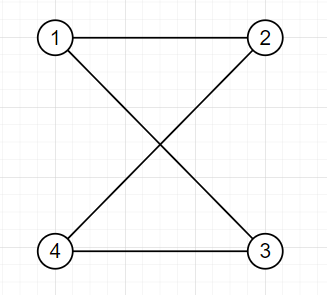

### Problem 2.3

Write down the set of all conditional independence relations on the undirected graph of $X$.

### Answer 2.3

The set contains all conditional independence where $\Omega_{ij} = 0:$
\begin{align*}
    X_1 &\perp X_2 \mid \{X_3, X_4, X_5, X_6\} \\
    X_3 &\perp X_5 \mid \{X_1, X_2, X_4, X_6\} \\
    X_3 &\perp X_6 \mid \{X_1, X_2, X_4, X_5\} \\
    X_4 &\perp X_5 \mid \{X_1, X_2, X_3, X_6\} \\
    X_4 &\perp X_6 \mid \{X_1, X_2, X_3, X_5\}
\end{align*}

## Problem 3: Taking stock (15 points)

A joint distribution of data has a natural graph associated with it. When the distribution is multivariate normal, this graph is encoded in the pattern of zeros and non-zeros in the inverse of the covariance matrix, also known as the "precision matrix."

In class we demonstrated the graphical lasso for estimating the graph on ETF data.
In this problem you will construct two different "portolios" of stocks,
and run the graphical lasso to estimate a graph, commenting on your results.

All of the code you might need for this is contained in the demo.


### Downloading data

As demonstrated in class, you will run on equities data downloaded from Yahoo finance.
Your job is to construct two "portfolios" of stocks, each of which has some kind of organization to it. For example, in one portfolio you might have 5 energy stocks, 5 tech stocks, 5 consumer staples stocks, and 5 ETF stocks. Each portfolio should have at least 20 stocks.

The page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies has GICS sectors, which you may find useful for the glasso problem.

To download the data, follow the procedure outlined below (and discussed briefly in class):

  * Search on a ticker symbol, like EZA, using [https://finance.yahoo.com/quote/EZA/history?p=EZA](https://finance.yahoo.com/quote/EZA/history?p=EZA)
  * Select the range of the query, the frequency (daily, weekly, or monthly) and then issue the query. This will give you results like this:
  
 ![ezh](https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/graphs/ezh.png)

  * Next, hover over the Download link, and grab the URL. In this case it gives
  https://query1.finance.yahoo.com/v7/finance/download/EZA?period1=1044576000&period2=1648080000&interval=1d&events=history&includeAdjustedClose=true
  
  * Then, you can use this same URL, but swap in different ticker symbols, to get the corresponding data for range of companies or funds.  


### Analyzing  your portfolios

Your task is to analyze each porfolio using the graphical lasso, and comment on your findings.
Here are the types of questions you should address:

* How did you choose the portolio? How did you choose the date range and frequency (daily, weekly, etc.)? Remember, each of the portfolios must contain at least 20 stocks, and be organized in some reasonable way.

* Display the graph obtained with the graphical lasso, using networkx. How did you choose the regularization level? Does the structure of the graph make sense? Is it sensitive to the choice of regularization level? Is this the structure you expected to see when you designed the portfolio? Why or why not?

* What are some of the conditional independence assumptions implied by the graph? Are some parts of the graph more densely connected than others? Why?




### Answer 3

In [327]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import mstats
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.covariance import GraphicalLasso

#### Data Logistics
1. price_d_sp500_2023.parquet.brotli is price data for all tickers in SP500 2023 ticker list.
2. wrds_link.parquet.brotli is linking data compiled from Wharton Research Data Service (WRDS) that links tickers with other identifies (i.e., permno, gvkey, etc.)
3. wrds_ind.parquet.brotli is industry data compiled from Wharton Research Data Service (WRDS) that contains industry information for the stocks. 

**Note: All of this data was compiled before by me for ongoing Finance Research at Yale SOM. This data is verified and tested in our research.**


In [158]:
price_d = pd.read_parquet('price_d_sp500_2023.parquet.brotli')
wrds_link = pd.read_parquet('wrds_link.parquet.brotli')
wrds_ind = pd.read_parquet('wrds_ind.parquet.brotli')

In [159]:
price_d

open    high     low   close  adj_close     volume  \
ticker date                                                               
A      2000-01-03   53.06   53.18   45.39   48.51      43.60  4962189.0   
       2000-01-04   45.90   46.40   43.63   44.17      39.70  5058514.0   
       2000-01-05   44.64   44.64   40.64   42.03      37.77  6113793.0   
       2000-01-06   41.52   41.77   39.16   39.75      35.73  2690591.0   
       2000-01-07   39.79   44.43   39.75   43.79      39.36  2993521.0   
...                   ...     ...     ...     ...        ...        ...   
ZTS    2023-12-22  195.32  195.91  192.74  194.98     193.99  1548412.0   
       2023-12-26  194.88  196.34  194.09  195.50     194.50   814641.0   
       2023-12-27  195.41  197.01  194.74  196.90     195.90   766411.0   
       2023-12-28  197.62  198.60  196.53  197.16     196.15   880094.0   
       2023-12-29  196.68  198.01  196.25  197.37     196.36  1007235.0   

                   unadj_volume  change  change_percent      vwap  \
ticker date                                                         
A      2000-01-03     4962189.0   -4.55        -8.58000   50.0350   
       2000-01-04     5058514.0   -1.73        -3.77000   45.0250   
       2000-01-05     6113793.0   -2.61        -5.85000   42.9875   
       2000-01-06     2690591.0   -1.77        -4.26000   40.5500   
       2000-01-07     2993521.0    4.00        10.05000   41.9400   
...                         ...     ...             ...       ...   
ZTS    2023-12-22     1548412.0   -0.34        -0.17407  194.7375   
       2023-12-26      814641.0    0.62         0.31814  195.2025   
       2023-12-27      766411.0    1.49         0.76250  196.0150   
       2023-12-28      880094.0   -0.46        -0.23277  197.4775   
       2023-12-29     1007235.0    0.69         0.35082  197.0775   

                             label  change_over_time  adj_factor  
ticker date                                                       
A      2000-01-03   January 03, 00         -0.085800    0.898784  
       2000-01-04   January 04, 00         -0.037700    0.898800  
       2000-01-05   January 05, 00         -0.058500    0.898644  
       2000-01-06   January 06, 00         -0.042600    0.898868  
       2000-01-07   January 07, 00          0.100500    0.898835  
...                            ...               ...         ...  
ZTS    2023-12-22  December 22, 23         -0.001741    0.994923  
       2023-12-26  December 26, 23          0.003181    0.994885  
       2023-12-27  December 27, 23          0.007625    0.994921  
       2023-12-28  December 28, 23         -0.002328    0.994877  
       2023-12-29  December 29, 23          0.003508    0.994883  

[2737829 rows x 13 columns]

In [160]:
print(price_d.index.get_level_values('ticker').unique().tolist())

['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DAY', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI',

In [161]:
wrds_link

,gvkey,conm,ticker,cusip,cik,sic,naics,linkprim,linktype,liid,permno,lpermco,timeLinkStart_d,timeLinkEnd_d
0,001000,A & E PLASTIK PAK INC,AE.2,000032102,None,3089,None,P,LU,01,25881,23369.0,1970-11-13,1978-06-30
1,001001,A & M FOOD SERVICES INC,AMFD.,000165100,0000723576,5812,722,P,LU,01,10015,6398.0,1983-09-20,1986-07-31
2,001002,AAI CORP,AAIC.1,000352104,0001306124,3825,None,C,LC,01,10023,22159.0,1972-12-14,1973-06-05
3,001003,A.A. IMPORTING CO INC,ANTQ,000354100,0000730052,5712,442110,C,LU,01,10031,6672.0,1983-12-07,1989-08-16
4,001004,AAR CORP,AIR,000361105,0000001750,5080,423860,P,LU,01,54594,20000.0,1972-04-24,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31533,349994,CLEARMIND MEDICINE INC,CMND,185053402,0001892500,2834,325412,P,LC,01,23514,59438.0,2022-11-15,2024-01-01
31534,350681,GETNET ADQUIRENCIA E,GET,37428A103,0001867325,7374,518210,P,LC,90,22205,58855.0,2021-10-22,2023-03-31
31535,351038,QUOIN PHARMACEUTICALS LTD,QNRX,74907L300,0001671502,2834,325412,P,LC,90,16161,55612.0,2021-10-29,2024-01-01
31536,352262,COOL COMPANY LTD,CLCO,G2415A113,0001944057,4400,4831,P,LC,01,23773,59507.0,2023-03-17,2024-01-01


In [162]:
wrds_ind

,ticker,ind,sub_ind
51,AAL,203020,20302010
83,PNW,551010,55101010
165,AMD,453010,45301020
213,APD,151010,15101040
338,SWKS,453010,45301020
...,...,...,...
45560,EPAM,451020,45102010
45676,XYL,201060,20106020
46149,CBRE,602010,60201040
46413,LYB,151010,15101010


#### Format Data

I choose to use weekly return data to reduce number of observations and computation time for GLasso, but also retain a sufficient amount of data for accurate estimatin of $\Omega$. I selected the date range from 2012 to 2018, as this period exhibits relatively stable "random" returns, unaffected by significant events such as the 2008 Financial Crisis or the 2020 COVID-19 pandemic.

In [185]:
# Create return data (use adj_close instead of close because this is yields more accurate backtest)
price_w = price_d.reset_index('ticker').groupby('ticker').resample('W').last()
price_w = price_w.drop('ticker', axis=1)
price_w['ret'] = price_w.groupby('ticker')['adj_close'].pct_change(1)

# Compute log returns
price_w['log_ret'] = np.log(1 + price_w['ret'])

# Winsorize log returns at 1% and 99%
price_w['log_ret'] = mstats.winsorize(price_w['log_ret'], limits=[0.01, 0.01])

In [217]:
# Add industry
price_ind = price_w.reset_index('date').join(wrds_ind.set_index('ticker')).reset_index().set_index(['ticker', 'date'])

# Set timeframe
price = price_ind.loc[(price_ind.index.get_level_values('date') >= '2012-01-01') & (price_ind.index.get_level_values('date') <= '2018-01-01')]

# Filter out any tickers that do not have same length of data from 2012 to 2018
price_unstack = price['log_ret'].unstack('ticker')
price_unstack = price_unstack.dropna(axis=1)
price = price.loc[price.index.get_level_values('ticker').isin(price_unstack.columns.get_level_values('ticker').unique())]
price = price.dropna(subset='ind')

In [218]:
# Display unique industrys
price.ind.unique()

array([352030., 203020., 452020., 403010., 451020., 451030., 453010.,
       202020., 551030., 551050., 151010., 351010., 201040., 352010.,
       402030., 601080., 255030., 201020., 101020., 452030., 251010.,
       601050., 551020., 601060., 151030., 551040., 201010., 402020.,
       255040., 302020., 253010., 101010., 601040., 351020., 602010.,
       303010., 203010., 502010., 401010., 301010., 402010., 202010.,
       452010., 203040., 252010., 502020., 201060., 551010., 303020.,
       201070., 601070., 251020., 502030., 255010., 252020., 601030.,
       352020., 302010., 252030., 151020., 151040., 601025., 302030.,
       201030., 501010.])

#### Create Portfolio
To enhance diversification and reduce risk, I construct two distinct portfolios. Each portfolio is built by randomly selecting 10 industries and, within each selected industry, randomly choosing up to 5 tickers. This approach ensures a broad spread across sectors while maintaining exposure within each industry.

In [219]:
# Create portfolio
def create_portfolio(price):
    # Randomly sample 10 industries
    unique_inds = price.ind.unique()
    sampled_inds = np.random.choice(unique_inds, size=10, replace=False)
    
    # Randomly sample maximum 5 tickers per industry
    sampled_tic = {}
    for ind in sampled_inds:
        tic_in_ind = price.loc[price.ind == ind].index.get_level_values('ticker').unique()
        ss = min(5, len(tic_in_ind))
        sampled_tic[ind] = np.random.choice(tic_in_ind, size=ss, replace=False).tolist()
    return sampled_tic

In [220]:
# Portfolio 1
port_1 = create_portfolio(price)
port_1_tic = list(set(ticker for tickers in port_1.values() for ticker in tickers))
port_1

{601060.0: ['ESS', 'CPT', 'EQR', 'UDR', 'AVB'],
 252030.0: ['LULU', 'TPR', 'VFC', 'RL', 'NKE'],
 302020.0: ['HRL', 'MKC', 'CAG', 'BG', 'SJM'],
 203010.0: ['FDX', 'CHRW', 'EXPD', 'UPS'],
 201060.0: ['XYL', 'IEX', 'SWK', 'PCAR', 'WAB'],
 403010.0: ['PGR', 'WTW', 'BRO', 'AIZ', 'AJG'],
 502010.0: ['IPG', 'CMCSA', 'PARA', 'CHTR', 'OMC'],
 501010.0: ['VZ'],
 151020.0: ['MLM', 'VMC'],
 301010.0: ['WBA', 'DG', 'SYY', 'TGT', 'COST']}

In [221]:
# Portfolio 2
port_2 = create_portfolio(price)
port_2_tic = list(set(ticker for tickers in port_2.values() for ticker in tickers))
port_2

{201030.0: ['PWR'],
 551010.0: ['LNT', 'EVRG', 'ES', 'PNW', 'NEE'],
 301010.0: ['SYY', 'DG', 'DLTR', 'TGT', 'WBA'],
 101010.0: ['BKR'],
 601050.0: ['VTR', 'ARE', 'WELL', 'DOC'],
 351020.0: ['CNC', 'COR', 'HUM', 'UNH', 'UHS'],
 402010.0: ['FIS', 'FI', 'V', 'CPAY', 'GPN'],
 601040.0: ['BXP'],
 502030.0: ['MTCH', 'GOOGL'],
 352030.0: ['WST', 'CRL', 'RVTY', 'ILMN', 'TMO']}

#### Estimate $\Omega$
I define a parameter grid and perform a 5-fold cross-validation for each parameter setting. For each fitted model, I compute the average likelihood score to assess risk. Finally, I refit the model using the parameter that achieved the lowest risk.

In [243]:
# Unstack price
log_ret = price[['log_ret']].unstack('ticker')
log_ret.columns = log_ret.columns.get_level_values('ticker')

In [320]:
# Compute cross-validation score for a given alpha
def compute_alpha_score(alpha, X, kf):
    cv_score = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        glasso = GraphicalLasso(alpha=alpha).fit(X_train)
        cv_score += -glasso.score(X_test)
    
    avg_score = cv_score / kf.get_n_splits()
    return alpha, avg_score

# 5 fold cross-validation over parameter space (parallelized per batch)
def glasso_cv_5(X, alpha_grid=np.linspace(0.1, 1.0, 100), batch_size=16):
    # Standardize
    X = np.array(X)
    p = X.shape[1]
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # 5-Fold Split
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    # Parallelize batch processing (i.e., run all alphas in batch at the same time)
    results = []
    num_batches = len(alpha_grid) // batch_size + (1 if len(alpha_grid) % batch_size != 0 else 0)
    
    for i in range(0, len(alpha_grid), batch_size):
        batch_alphas = alpha_grid[i:i + batch_size]
        batch_results = Parallel(n_jobs=-1)(delayed(compute_alpha_score)(alpha, X, kf) for alpha in batch_alphas)
        results.extend(batch_results)
        print(f"Progress: {(i // batch_size) + 1}/{num_batches}")
    
    # Format results
    results_df = pd.DataFrame(results, columns=['alpha', 'score'])
    
    # Plot alpha vs. score
    plt.plot(results_df['alpha'], results_df['score'], marker='o')
    plt.xlabel('Alpha')
    plt.ylabel('Score')
    plt.title('Cross-Validation Score vs. Alpha')
    plt.show()
    
    # Get best alpha
    best_alpha = results_df.loc[results_df['score'].idxmin(), 'alpha']
    print(f"Best alpha: {best_alpha}\n")
    
    # Refit model using best alpha
    glasso_best = GraphicalLasso(alpha=best_alpha).fit(X)
    Omega_hat = glasso_best.precision_
    
    # Set diagonal elements to 0 for visualization
    for j in np.arange(p):
            Omega_hat[j,j] = 0
    
    # Plot heatmap of the precision matrix
    sns.heatmap(Omega_hat, cmap='jet')
    plt.show()
    
    # Return the fitted precision matrix and results DataFrame
    return Omega_hat

In [321]:
# Params
port_1_X = log_ret[port_1_tic]
port_2_X = log_ret[port_2_tic]
alpha_grid = np.linspace(0, 1, 100)
batch_size = 16

<Axes: xlabel='date'>

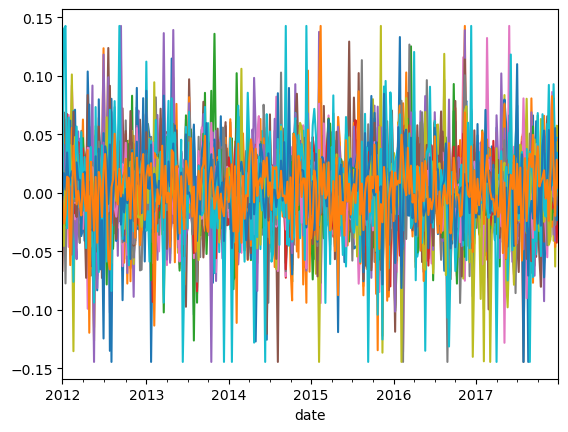

In [322]:
# Port 1 (I looks normal!)
port_1_X.plot(legend=False)

<Axes: xlabel='date'>

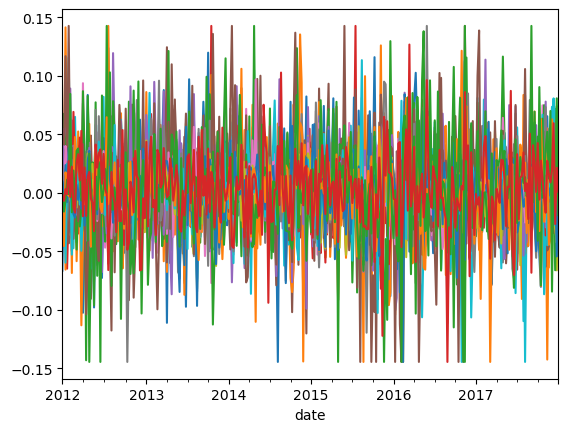

In [323]:
# Port 2 (I looks normal!)
port_2_X.plot(legend=False)

Progress: 1/7
Progress: 2/7
Progress: 3/7
Progress: 4/7
Progress: 5/7
Progress: 6/7
Progress: 7/7


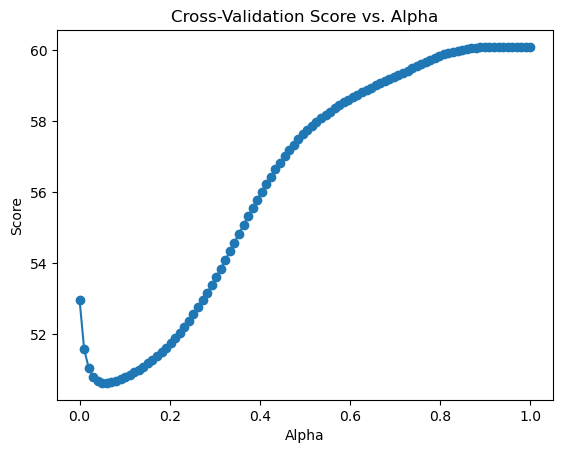

Best alpha: 0.06060606060606061



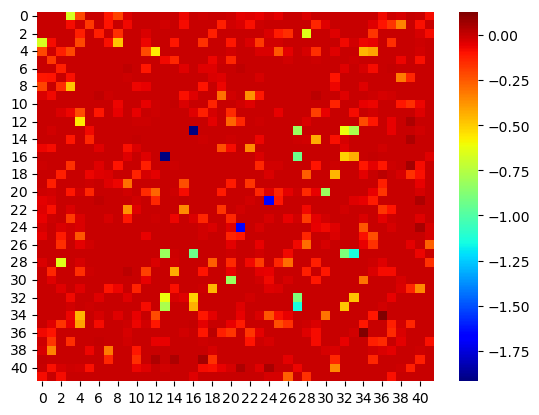

In [324]:
# Run Port 1
Omega_port_1 = glasso_cv_5(port_1_X, alpha_grid, batch_size)

Progress: 1/7
Progress: 2/7
Progress: 3/7
Progress: 4/7
Progress: 5/7
Progress: 6/7
Progress: 7/7


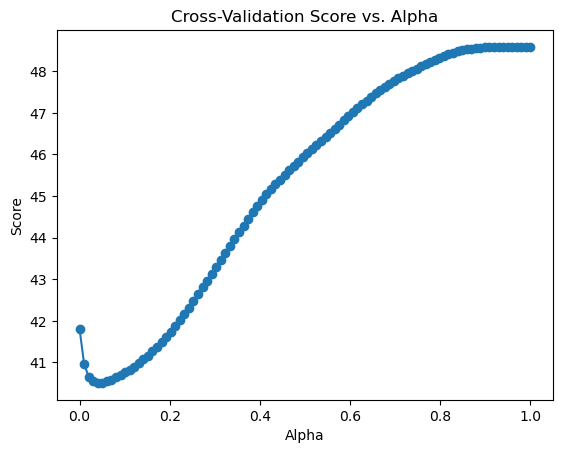

Best alpha: 0.04040404040404041



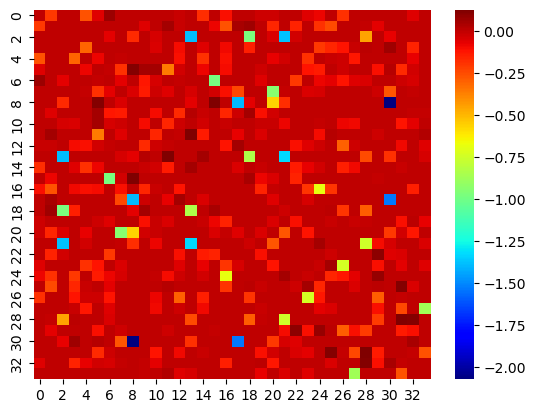

In [325]:
# Run Port 2
Omega_port_2 = glasso_cv_5(port_2_X, alpha_grid, batch_size)

#### Plot Graph

In [342]:
def plot_precision_graph(Omega, tickers, threshold=0.1, figsize=(8, 8)):
    # Convert precision matrix
    precdf = pd.DataFrame(Omega, columns=tickers, index=tickers)
    links = precdf.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links = links[(abs(links['value']) > threshold) & (links['var1'] != links['var2'])]

    # Build the graph
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', create_using=nx.Graph())
    pos = nx.spring_layout(G, k=1.7/np.sqrt(len(G.nodes())), iterations=20)

    # Draw the graph
    plt.figure(figsize=figsize)
    nx.draw(G, pos=pos, node_size=50, edge_color="gray", node_color="skyblue", with_labels=False)
    nx.draw_networkx_labels(G, pos=pos, font_size=8)
    plt.show()

In [343]:
port_1

{601060.0: ['ESS', 'CPT', 'EQR', 'UDR', 'AVB'],
 252030.0: ['LULU', 'TPR', 'VFC', 'RL', 'NKE'],
 302020.0: ['HRL', 'MKC', 'CAG', 'BG', 'SJM'],
 203010.0: ['FDX', 'CHRW', 'EXPD', 'UPS'],
 201060.0: ['XYL', 'IEX', 'SWK', 'PCAR', 'WAB'],
 403010.0: ['PGR', 'WTW', 'BRO', 'AIZ', 'AJG'],
 502010.0: ['IPG', 'CMCSA', 'PARA', 'CHTR', 'OMC'],
 501010.0: ['VZ'],
 151020.0: ['MLM', 'VMC'],
 301010.0: ['WBA', 'DG', 'SYY', 'TGT', 'COST']}

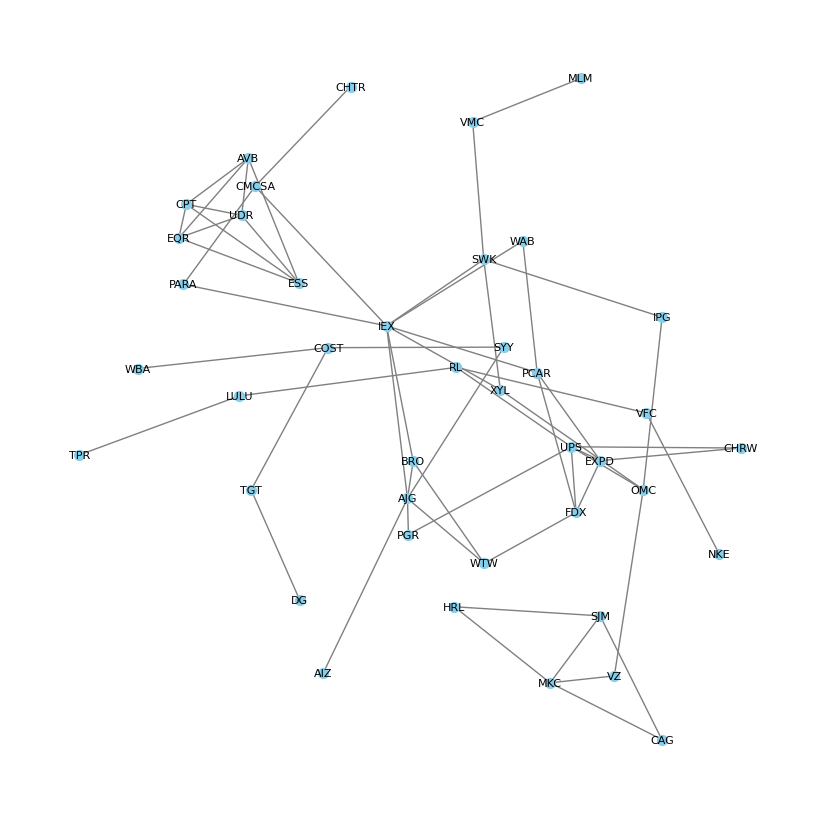

In [348]:
plot_precision_graph(Omega_port_1, port_1_tic, threshold=0.15)

In [340]:
port_2

{201030.0: ['PWR'],
 551010.0: ['LNT', 'EVRG', 'ES', 'PNW', 'NEE'],
 301010.0: ['SYY', 'DG', 'DLTR', 'TGT', 'WBA'],
 101010.0: ['BKR'],
 601050.0: ['VTR', 'ARE', 'WELL', 'DOC'],
 351020.0: ['CNC', 'COR', 'HUM', 'UNH', 'UHS'],
 402010.0: ['FIS', 'FI', 'V', 'CPAY', 'GPN'],
 601040.0: ['BXP'],
 502030.0: ['MTCH', 'GOOGL'],
 352030.0: ['WST', 'CRL', 'RVTY', 'ILMN', 'TMO']}

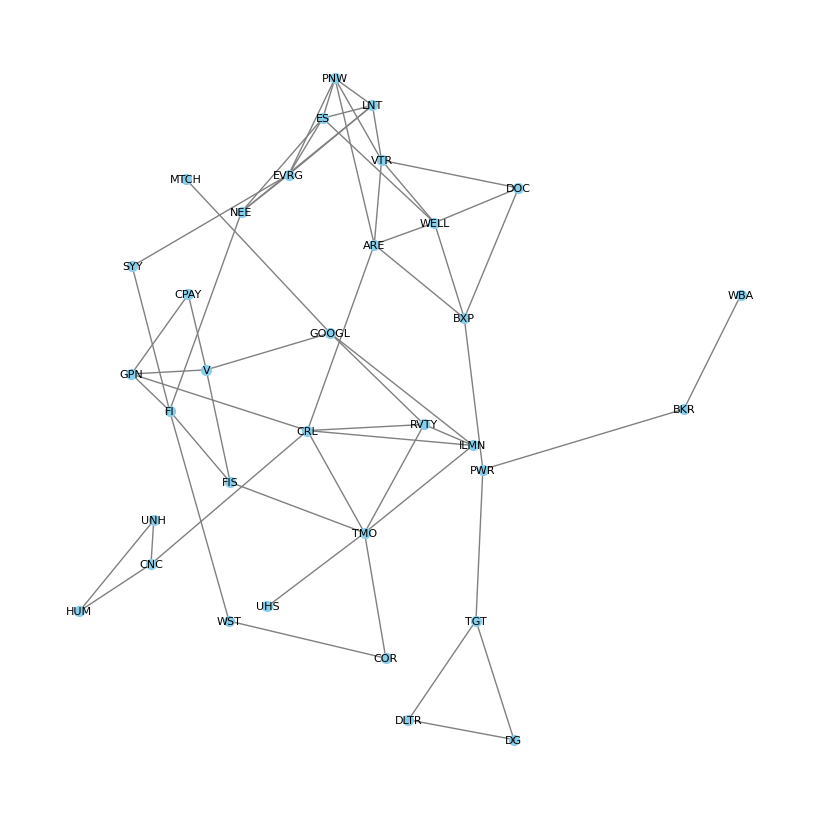

In [349]:
plot_precision_graph(Omega_port_2, port_2_tic, threshold=0.15)

I selected a regularization parameter of 0.15, as it provided the best alignment with the industry-to-ticker mapping. For example, in the plot, GOOGL is connected to MTCH, which makes sense since both belong to the same industry of Tech. When the regularization threshold is set too low, the plot becomes noisy, with excessive edges connecting stocks across different industries, making it harder to interpret. Too high regularization yields no points and connections. With the chosen regularization, we observe clear clusters of stocks, indicating connections both within and across industries. For instance, GOOGL is connected to CRL, linking the tech and pharma sectors, which reflects the real-world connection between these industries. However, it's crucial to highlight that GOOGL is conditionally independent of WBA (Walgreens) given the other return data, even though WBA is also in the pharma sector. This insight suggests that the threshold could be adjusted ad hoc based on this domain knowledge.

Overall, the graph aligns with expectations based on the portfolio construction method of randomly selecting 10 distinct industries and stocks within each industry. It’s reasonable to anticipate conditional independence between sectors like Tech and contrasting ones, which is reflected in pairs such as GOOGL (Tech) and HMA (Insurance). This makes sense, as a new GOOGL search engine upgrade is unlikely to impact the Insurance sector, which relies more on factors like human trust.